In [1]:
%%capture
!unzip data/data.zip -d data/

In [2]:
from IPython.display import Image
import pandas as pd

### Content Based Filtering

The task of the recommender engine is to recommend one of the three candidate movies to this user, or in other, words we want to predict what the user's possible rating would be of the three candidate movies if she were to watch them. To achieve this, we have to build the user profile. First, we create a vector to show the user's ratings for the movies that she's already watched. We call it Input User Ratings. Then, we encode the movies through the one-hot encoding approach. Genre of movies are used here as a feature set. We use the first three movies to make this matrix, which represents the movie feature set matrix. If we multiply these two matrices we can get the weighted feature set for the movies. Let's take a look at the result. This matrix is also called the Weighted Genre matrix and represents the interests of the user for each genre based on the movies that she's watched. Now, given the Weighted Genre Matrix, we can shape the profile of our active user. 

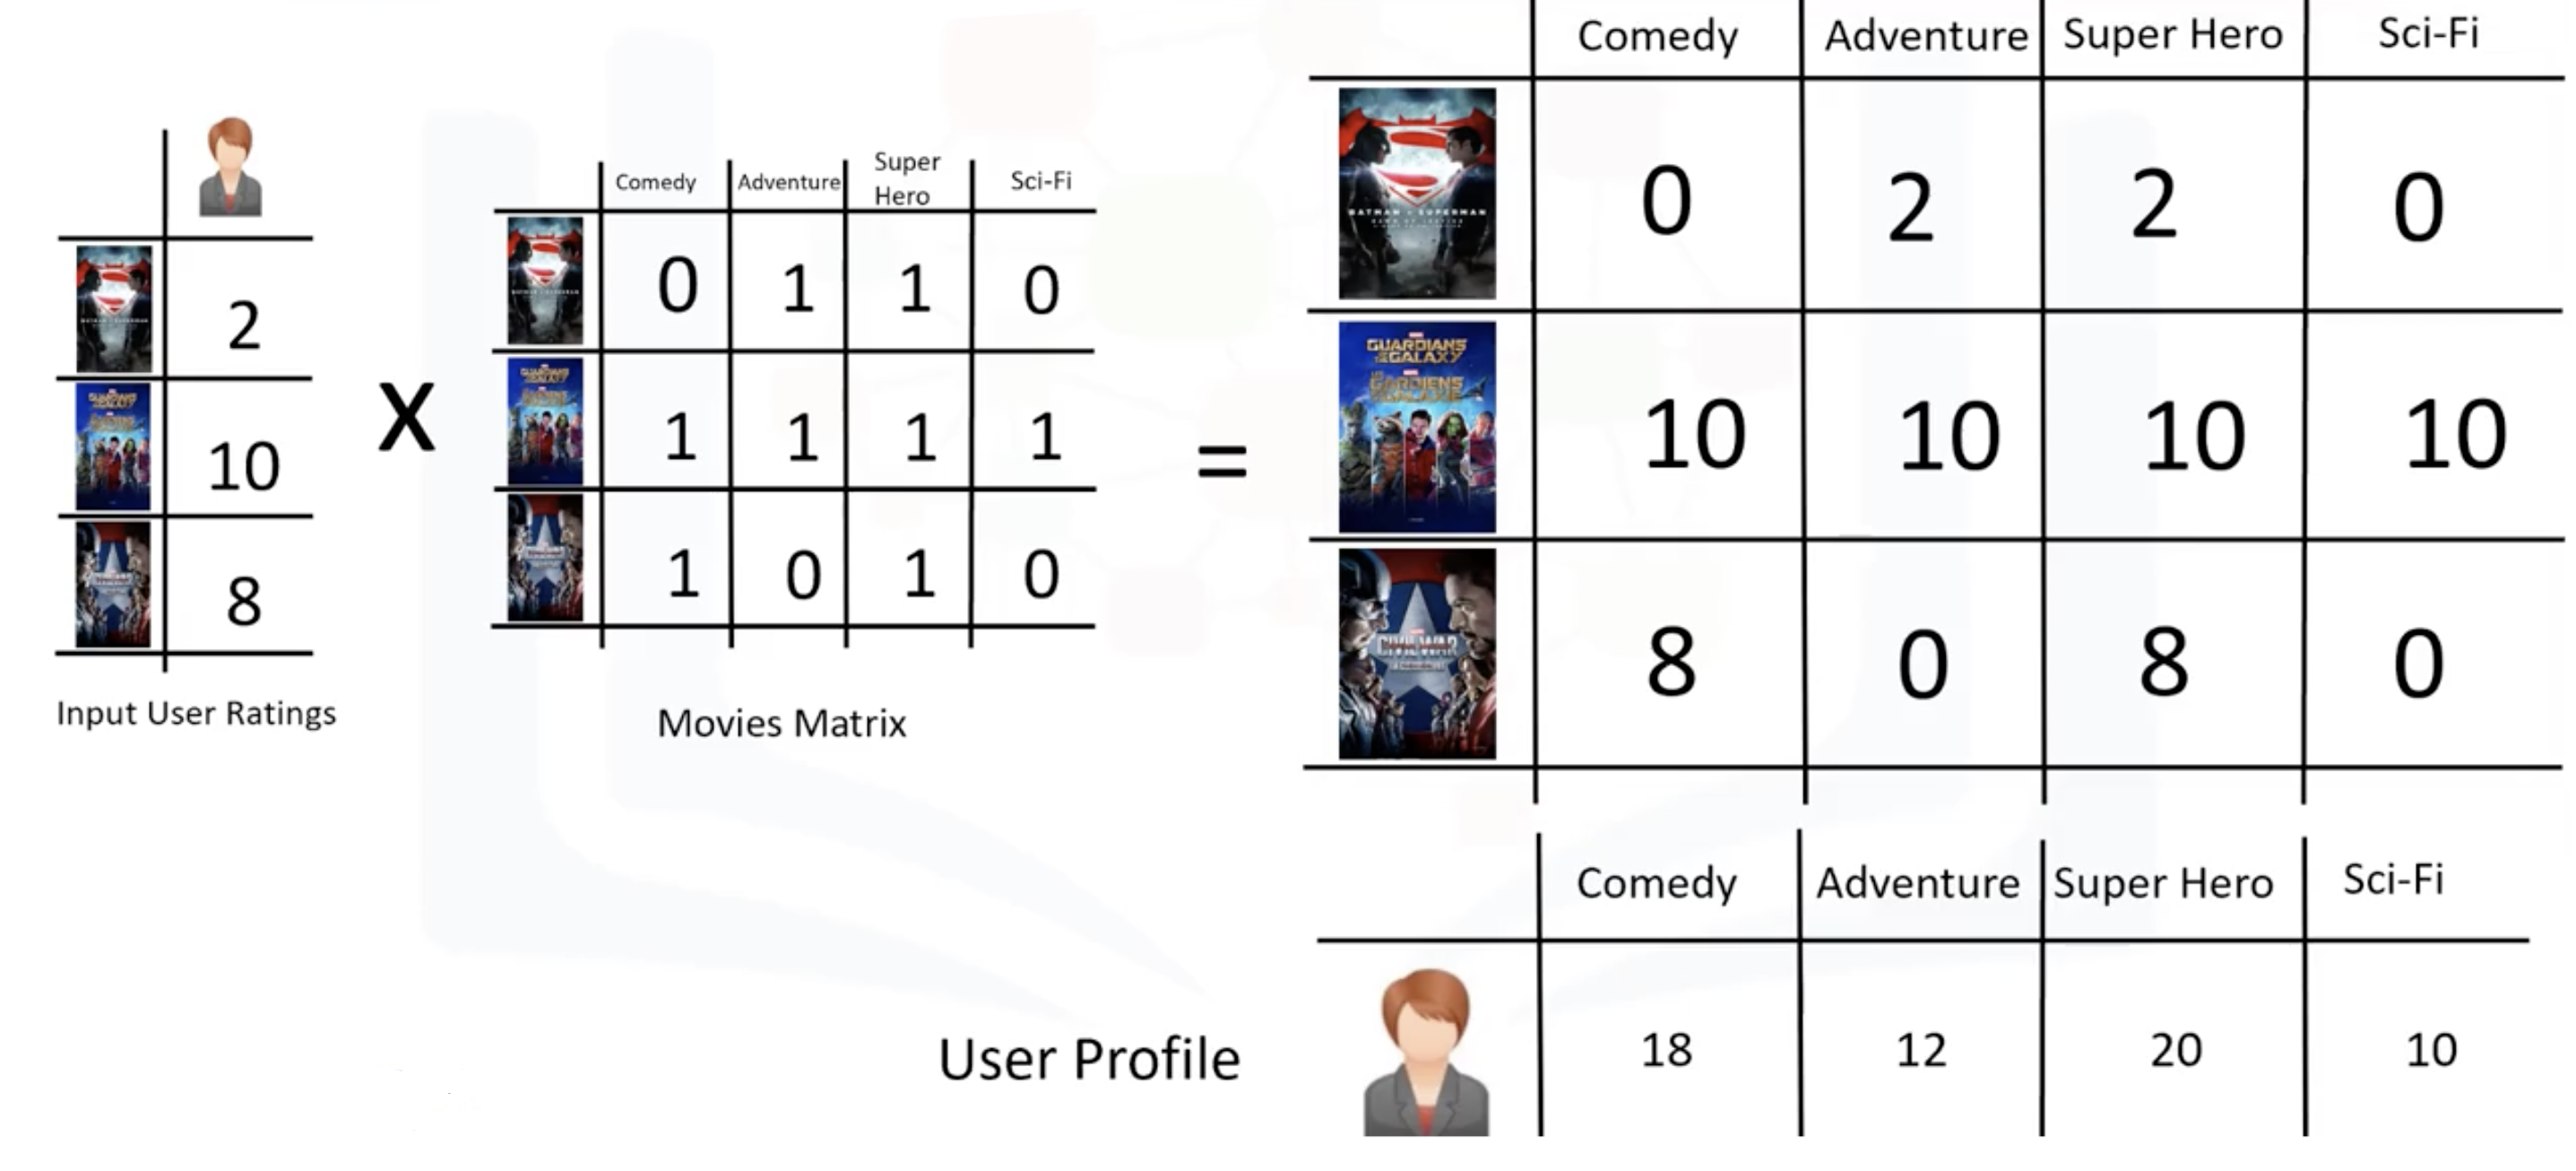

In [3]:
Image('img/form-1.png', width=800, height=400)

Essentially, we can aggregate the weighted genres and then normalize them to find the user profile. It clearly indicates that she likes superhero movies more than other genres. We use this profile to figure out what movie is proper to recommend to this user.

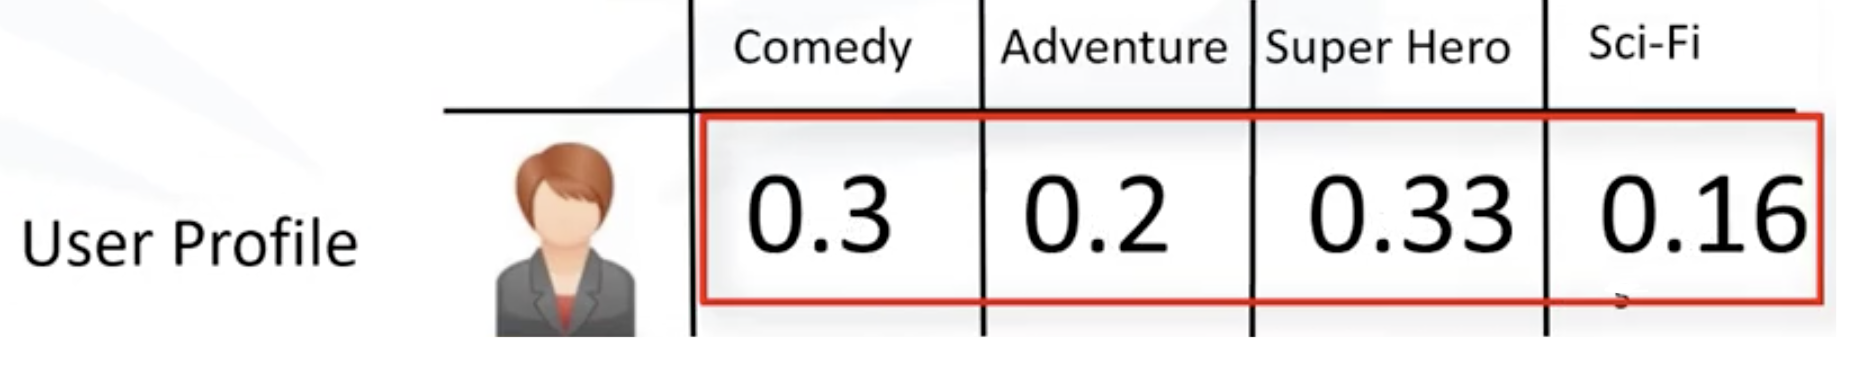

In [4]:
Image('img/form-2.png', width=800, height=400)

What would the user think of new movies?

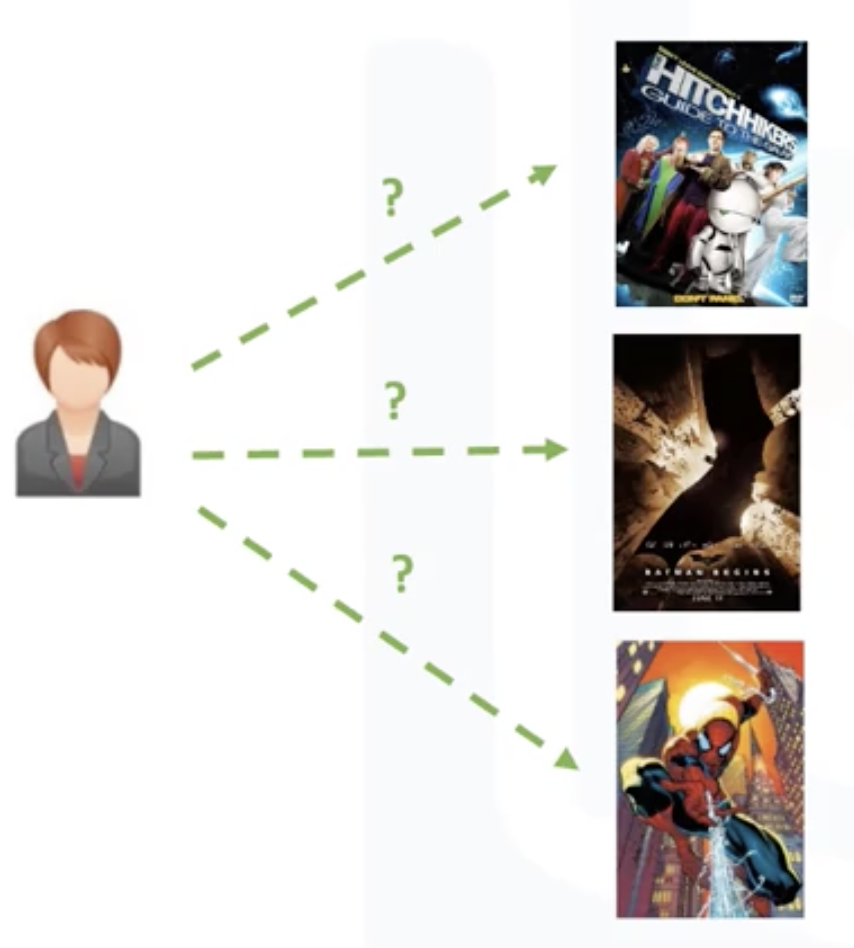

In [5]:
Image('img/form-3.png', width=400, height=100)

Now we're in the position where we have to figure out which of the above movies is most suited to be recommended to the user. To do this, we simply multiply the User Profile matrix by the candidate Movie Matrix, which results in the Weighted Movies Matrix. It shows the weight of each genre with respect to the User Profile. Now, if we aggregate these weighted ratings, we get the active user's possible interest level in these three movies. In essence, it's our recommendation lists, which we can sort to rank the movies and recommend them to the user. 

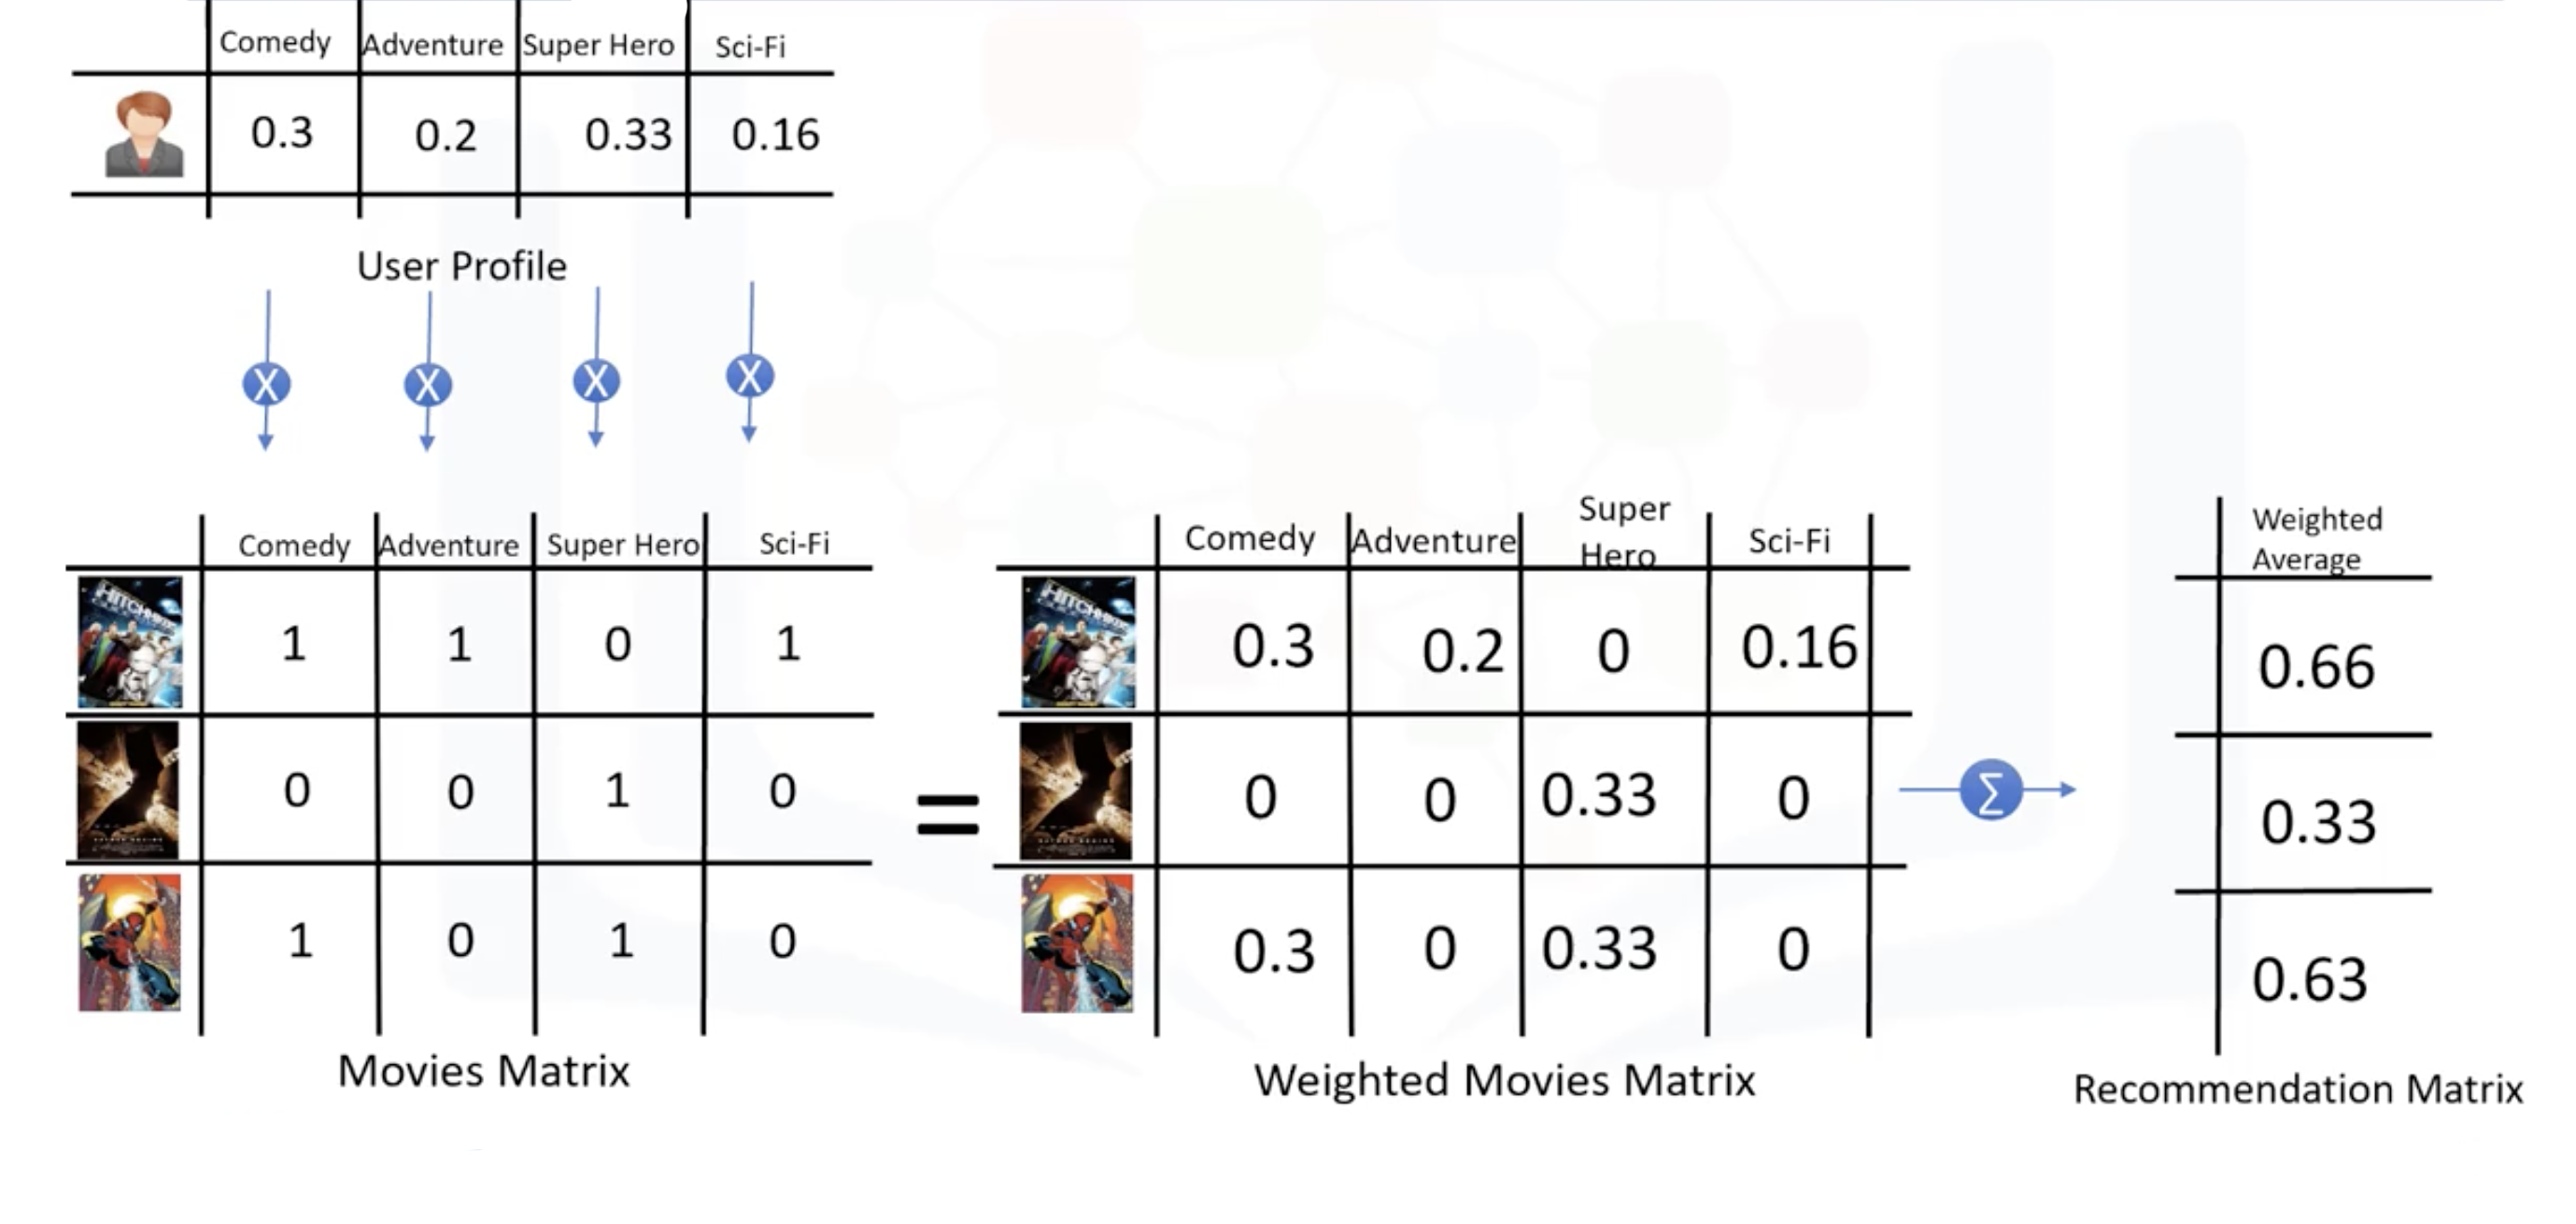

In [6]:
Image('img/form-4.png', width=800, height=400)

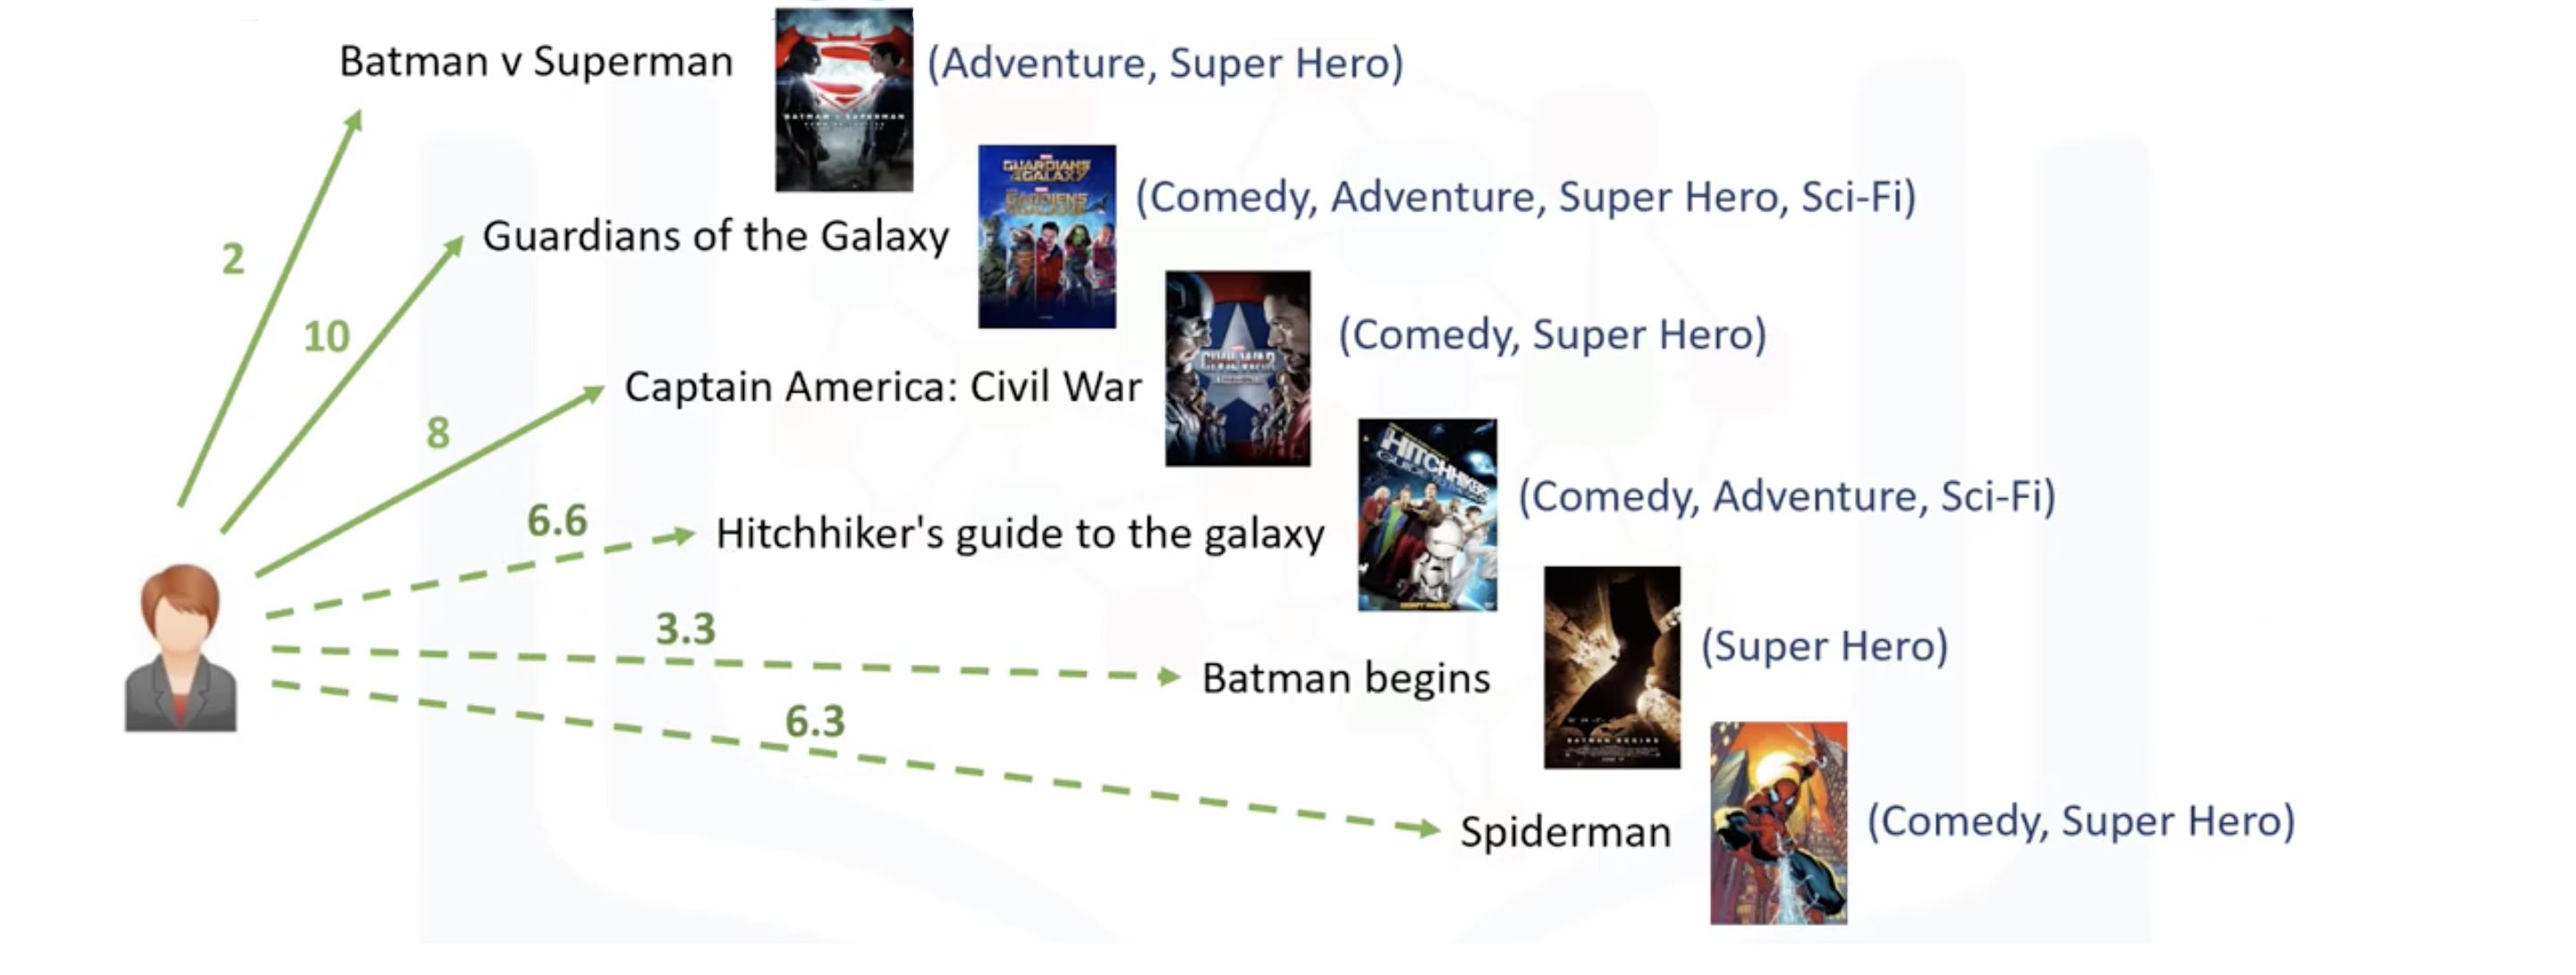

In [7]:
Image('img/form-5.png', width=800, height=400)

Let's coding this!

In [8]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

In [9]:
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))', expand=False)
movies['year'] = movies.year.str.extract('(\d\d\d\d)', expand=False)
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [10]:
movies['genres'] = movies.genres.str.split('|')

In [11]:
ratings = ratings.drop('timestamp', axis=1)

Since keeping genres in a list format isn't optimal for the content-based recommendation system technique, we will use the One Hot Encoding technique to convert the list of genres to a vector where each column corresponds to one possible value of the feature. This encoding is needed for feeding categorical data. In this case, we store every different genre in columns that contain either 1 or 0. 1 shows that a movie has that genre and 0 shows that it doesn't.

In [12]:
dummies = pd.get_dummies(movies['genres'].apply(pd.Series).stack()).sum(level=0)
dfs = [
    movies.drop('genres', axis=1),
    dummies
]
movies = pd.concat(dfs, axis=1)

Now, let's take a look at how to implement **Content-Based** or **Item-Item recommendation systems**. This technique attempts to figure out what a user's favourite aspects of an item is, and then recommends items that present those aspects. In our case, we're going to try to figure out the input's favorite genres from the movies and ratings given.

Let's begin by creating an input user to recommend movies to:

#### Add movieId to input user

With the input complete, let's extract the input movie's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movie's title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [13]:
user_input = [
    {
        'movieId': 1968,
        'title': 'Breakfast Club, The', 
        'rating': 5
    },
    {
        'movieId': 1,
        'title': 'Toy Story', 
        'rating': 3.5
    },
    {
        'movieId': 2,
        'title': 'Jumanji', 
        'rating': 2
    },
    {
        'movieId': 296,
        'title': 'Pulp Fiction', 
        'rating': 5
    },
    {
        'movieId': 1274,
        'title': 'Akira', 
        'rating': 4.5
    }
] 
input_movies = pd.DataFrame(user_input).sort_values('movieId').reset_index(drop=True)

In [14]:
input_movies

movieId                title  rating
0        1            Toy Story     3.5
1        2              Jumanji     2.0
2      296         Pulp Fiction     5.0
3     1274                Akira     4.5
4     1968  Breakfast Club, The     5.0

We're going to start by learning the input's preferences, so let's get the subset of movies that the input has watched from the Dataframe containing genres defined with binary values.


In [15]:
user_movies = movies[movies['movieId'].isin(input_movies['movieId'].tolist())]

In [16]:
user_movies.head()

movieId                title  year  (no genres listed)  Action  \
0           1            Toy Story  1995                   0       0   
1           2              Jumanji  1995                   0       0   
293       296         Pulp Fiction  1994                   0       0   
1246     1274                Akira  1988                   0       1   
1885     1968  Breakfast Club, The  1985                   0       0   

      Adventure  Animation  Children  Comedy  Crime  ...  Film-Noir  Horror  \
0             1          1         1       1      0  ...          0       0   
1             1          0         1       0      0  ...          0       0   
293           0          0         0       1      1  ...          0       0   
1246          1          1         0       0      0  ...          0       0   
1885          0          0         0       1      0  ...          0       0   

      IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0        0        0       0         0    0        0  
1        0        0        0        0       0         0    0        0  
293      0        0        0        0       0         1    0        0  
1246     0        0        0        0       1         0    0        0  
1885     0        0        0        0       0         0    0        0  

[5 rows x 23 columns]

In [17]:
user_movies = user_movies.reset_index(drop=True)
user_genres = user_movies.drop(columns=['movieId', 'title', 'year'])

In [18]:
user_genres

(no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      1   
3                   0       1          1          1         0       0      0   
4                   0       0          0          0         0       1      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  \
0            0      0        1          0       0     0        0        0   
1            0      0        1          0       0     0        0        0   
2            0      1        0          0       0     0        0        0   
3            0      0        0          0       0     0        0        0   
4            0      1        0          0       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0       0         0    0        0  
1        0       0         0    0        0  
2        0       0         1    0        0  
3        0       1         0    0        0  
4        0       0         0    0        0

In [19]:
input_movies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
4    5.0
Name: rating, dtype: float64

Now we're ready to start learning the input's preferences!

To do this, we're going to turn each genre into weights. We can do this by using the input's reviews and multiplying them into the input's genre table and then summing up the resulting table by column. This operation is actually a dot product between a matrix and a vector, so we can simply accomplish by calling Pandas' `dot` function.

In [20]:
profile = user_genres.transpose().dot(input_movies['rating'])

Now, we have the weights for every of the user's preferences. This is known as the User Profile. Using this, we can recommend movies that satisfy the user's preferences.

In [21]:
genre_table = movies.set_index('movieId').drop(columns=['title', 'year'])

With the input's profile and the complete list of movies and their genres in hand, we're going to take the weighted average of every movie based on the input profile and recommend the top twenty movies that most satisfy it.

In [22]:
recommendations = ((genre_table * profile).sum(axis=1)) / (profile.sum())

In [23]:
recommendations = recommendations.sort_values(ascending=False)

In [24]:
movies.loc[movies['movieId'].isin(recommendations.head(20).keys())]

movieId                                              title  year  \
664        673                                          Space Jam  1996   
1824      1907                                              Mulan  1998   
2902      2987                           Who Framed Roger Rabbit?  1988   
4923      5018                                           Motorama  1991   
6793      6902                                      Interstate 60  2002   
8605     26093         Wonderful World of the Brothers Grimm, The  1962   
8783     26340  Twelve Tasks of Asterix, The (Les douze travau...  1976   
9296     27344  Revolutionary Girl Utena: Adolescence of Utena...  1999   
9825     32031                                             Robots  2005   
11716    51632                            Atlantis: Milo's Return  2003   
11751    51939                TMNT (Teenage Mutant Ninja Turtles)  2007   
13250    64645                                  The Wrecking Crew  1968   
16055    81132                                             Rubber  2010   
18312    91335                                      Gruffalo, The  2009   
22778   108540           Ernest & Célestine (Ernest et Célestine)  2012   
22881   108932                                     The Lego Movie  2014   
25218   117646                     Dragonheart 2: A New Beginning  2000   
26442   122787                                       The 39 Steps  1959   
32854   146305                             Princes and Princesses  2000   
33509   148775                Wizards of Waverly Place: The Movie  2009   

       (no genres listed)  Action  Adventure  Animation  Children  Comedy  \
664                     0       0          1          1         1       1   
1824                    0       0          1          1         1       1   
2902                    0       0          1          1         1       1   
4923                    0       0          1          0         0       1   
6793                    0       0          1          0         0       1   
8605                    0       0          1          1         1       1   
8783                    0       1          1          1         1       1   
9296                    0       1          1          1         0       1   
9825                    0       0          1          1         1       1   
11716                   0       1          1          1         1       1   
11751                   0       1          1          1         1       1   
13250                   0       1          1          0         0       1   
16055                   0       1          1          0         0       1   
18312                   0       0          1          1         1       1   
22778                   0       0          1          1         1       1   
22881                   0       1          1          1         1       1   
25218                   0       1          1          0         0       1   
26442                   0       1          1          0         0       1   
32854                   0       0          0          1         1       1   
33509                   0       0          1          0         1       1   

       Crime  ...  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  \
664        0  ...          0       0     0        0        0        0       1   
1824       0  ...          0       0     0        1        0        1       0   
2902       1  ...          0       0     0        0        1        0       0   
4923       1  ...          0       0     0        0        1        0       1   
6793       0  ...          0       0     0        0        1        0       1   
8605       0  ...          0       0     0        1        0        1       0   
8783       0  ...          0       0     0        0        0        0       0   
9296       0  ...          0       0     0        0        0        1       0   
9825       0  ...          0       0     1        0        0        0       1   
117

#### Advantages and Disadvantages of Content-Based Filtering

##### Advantages

- Learns user's preferences
- Highly personalized for the user

##### Disadvantages

- Doesn't take into account what others think of the item, so low quality item recommendations might happen
- Extracting data is not always intuitive
- Determining what characteristics of the item the user dislikes or likes is not always obvious